# Approximating the position-dependent flux of a one-dimensional slab with an internal varying source distribution using DeepONet


## Problem definition and theoretical background

We consider a one dimensional slab of length $10\,cm$ with zero incoming currents, i.e., vacuum boundary conditions.

<u> Reference: </u> <br/>
Sahadath, M. H., Cheng, Q., Pan, S., & Ji, W. (2025, April). Deep Operator Network Based Surrogate Model for Neutron Transport Computation. In *Proceedings of International Conference on Mathematics and Computational Methods Applied to Nuclear Science & Engineering (M&C2025), Denver CO, USA*. Available at: https://doi.org/10.13182/xyz-47261

### Solution procedure

At each iteration of the source iteration technique:

- Compute the total source in every cell, combining the scattering source ($\frac{\Sigma_s \phi_j}{2}$) and the fixed internal non-homogeneous source ($\frac{Q_j}{2}$): $$ S_j = \frac{1}{2} (\Sigma_s \phi_j + Q_j) $$
  
- Sweep across the slab to compute the new angular fluxes $\psi_{n,j}$. For $\mu_n>0$, sweep left to right (neutrons moving toward $+x$). For $\mu_n<0$, sweep right to left (neutrons moving toward $-x$). Use the diamond-difference (DD) recurrence relation with $A=\frac{2|\mu_n|}{h}$: $$ (A+\Sigma_t)\psi_{n,j+\frac{1}{2}} = 2S_j + (A-\Sigma_t)\psi_{n,j-\frac{1}{2}} $$

- Compute the cell-averaged angular fluxes as follows: $$ \psi_{n,j} = \frac{1}{2}(\psi_{n,j+\frac{1}{2}} + \psi_{n,j-\frac{1}{2}}) $$

- Update the scalar flux as follows: $$ \phi_j = \sum_n w_n \psi_{n,j} $$

- Repeat until convergence ($\epsilon$ denotes the tolerance, i.e., the prescribed convergence criterion): $$ \max_j \frac{|\phi_j^{(k+1)} - \phi_j^{(k)}|}{\max\left(1,\, |\phi_j^{(k+1)}|\right)} < \epsilon $$ In other words, the iterations stop when the maximum absolute difference between the new and the old scalar flux estimates is less than $\epsilon$. Note that $k$ denotes the number of source iterations.

## Code for numerical solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def SN_1D_Slab(
    X=10.0,                 # cm, slab length (total width of the medium)
    h=0.1,                  # cm, width of each spatial cell
    Sigma_t=1.0,            # cm^-1, total macroscopic cross section
    Sigma_a=0.5,            # cm^-1, absorption cross section
    Q=None,                 # external (fixed) neutron source per cell; array of length J
    N=32,                   # number of discrete angular directions (S_N quadrature points)
    tol=1e-8,               # convergence tolerance for source iteration
    max_iters=10000         # maximum allowed source iterations
):
    # ------------------------------------------------------------
    # Compute number of spatial cells
    # ------------------------------------------------------------
    J = int(round(X / h))   # total number of uniform cells in the slab
                            # Example: X=10, h=0.1 -> J=100 cells

    # ------------------------------------------------------------
    # Compute scattering cross section
    # ------------------------------------------------------------
    Sigma_s = Sigma_t - Sigma_a   # isotropic scattering (Σ_t = Σ_a + Σ_s)

    # ------------------------------------------------------------
    # Define source term (if user didn’t provide one)
    # ------------------------------------------------------------
    if Q is None:
        # Default: uniform unit source in each cell (to be replaced by GRF)
        Q = np.ones(J)

    # ------------------------------------------------------------
    # Angular quadrature setup using Gauss–Legendre
    # ------------------------------------------------------------
    #   mu : cosine of polar angle for each discrete ordinate (-1 ≤ μ ≤ 1)
    #   w  : corresponding integration weights
    mu, w = np.polynomial.legendre.leggauss(N)

    # |μ| is used frequently in sweep equations (direction magnitude only)
    abs_mu = np.abs(mu)



    
    # Initialize arrays used in the S_N transport solver
    
    # Scalar flux at each spatial cell center.
    # φ_j represents the total neutron flux integrated over all directions (angle-averaged).
    # Shape: (J,)
    # Initially zero because we start source iteration with no prior flux estimate.
    phi = np.zeros(J)
    
    # Angular flux inside each cell for every discrete direction μ_n.
    # ψ[n, j] corresponds to the average angular flux in cell j for direction index n.
    # Shape: (N, J) — N discrete angles × J spatial cells.
    # This is what we compute during each sweep (for each n).
    psi_cell = np.zeros((N, J))
    
    # Angular flux at the LEFT edges of each cell for every direction μ_n.
    # ψ_edge_L[n, j] is the flux entering the left boundary of cell j (i.e., position x_{j-1/2}).
    # We need J+1 entries because there are J cells but J+1 cell edges (including both boundaries).
    # Shape: (N, J+1)
    psi_edge_L = np.zeros((N, J+1))
    
    # Angular flux at the RIGHT edges of each cell for every direction μ_n.
    # ψ_edge_R[n, j] is the flux exiting the right boundary of cell j (i.e., position x_{j+1/2}).
    # Also J+1 because we include the outer boundary at x = X.
    # These arrays are filled during the transport sweeps (L→R and R→L).
    # Shape: (N, J+1)
    psi_edge_R = np.zeros((N, J+1))


    for it in range(max_iters):
        # --------------------------------------------------------
        # Store the scalar flux from previous iteration
        # --------------------------------------------------------
        phi_old = phi.copy()
    
        # --------------------------------------------------------
        # Compute the isotropic source for this iteration
        # q_j = 0.5 * (Σ_s * φ_j + Q_j)
        # --------------------------------------------------------
        q = 0.5 * (Sigma_s * phi + Q)
    
        # --------------------------------------------------------
        # Reset angular flux storage for this iteration
        # We'll overwrite these with the new sweep results.
        # --------------------------------------------------------
        psi_cell.fill(0.0)
    
        # ========================================================
        #  SWEEP 1: POSITIVE μ directions (neutrons moving right)
        # ========================================================
        for n in np.where(mu > 0)[0]:         # loop over all μ_n > 0
            A = 2.0 * abs_mu[n] / h           # spatial coupling coefficient (2|μ|/Δx)
    
            # Boundary condition: vacuum at x = 0 → no incoming flux
            psi_edge_L[n, 0] = 0.0
    
            # Sweep cell by cell from left → right
            for j in range(J):
                # Diamond-difference recurrence:
                # (A + Σ_t) ψ_{n,j+1/2} = 2q_j + (A - Σ_t) ψ_{n,j-1/2}
                psi_edge_R[n, j] = (2.0 * q[j] + (A - Sigma_t) * psi_edge_L[n, j]) / (A + Sigma_t)
    
                # Cell-average angular flux ψ_{n,j} = 0.5(ψ_{n,j+1/2} + ψ_{n,j-1/2})
                psi_cell[n, j] = 0.5 * (psi_edge_R[n, j] + psi_edge_L[n, j])
    
                # Outgoing flux from this cell becomes incoming flux for the next one
                psi_edge_L[n, j+1] = psi_edge_R[n, j]
    
        # ========================================================
        #  SWEEP 2: NEGATIVE μ directions (neutrons moving left)
        # ========================================================
        for n in np.where(mu < 0)[0]:         # loop over all μ_n < 0
            A = 2.0 * abs_mu[n] / h           # spatial coupling coefficient (same as before)
    
            # Boundary condition: vacuum at x = X → no incoming flux
            psi_edge_R[n, J] = 0.0
    
            # Sweep from right → left
            for j in range(J-1, -1, -1):
                # Recurrence relation for left-moving neutrons:
                # (A + Σ_t) ψ_{n,j-1/2} = 2q_j + (A - Σ_t) ψ_{n,j+1/2}
                psi_edge_L[n, j] = (2.0 * q[j] + (A - Sigma_t) * psi_edge_R[n, j+1]) / (A + Sigma_t)
    
                # Compute cell-average flux
                psi_cell[n, j] = 0.5 * (psi_edge_R[n, j+1] + psi_edge_L[n, j])
    
                # Store outgoing flux from this cell (toward left)
                psi_edge_R[n, j] = psi_edge_L[n, j]
    
        # --------------------------------------------------------
        # Update scalar flux using angular flux moments
        # φ_j = Σ_n w_n ψ_{n,j}
        # --------------------------------------------------------
        phi = (psi_cell * w[:, None]).sum(axis=0)
    
        # --------------------------------------------------------
        # Check for convergence (relative change)
        # --------------------------------------------------------
        err = np.max(np.abs(phi - phi_old) / np.maximum(1.0, np.abs(phi)))
    
        # # Print status every 20 iterations
        # if it % 20 == 0:
        #     print(f"Iteration {it:5d}: relative change = {err:.3e}")
    
        # Convergence condition met → exit loop
        if err < tol:
            print(f"Flux converged in {it+1} iterations with relative change = {err:.3e}")
            break
    
    # ------------------------------------------------------------
    # If we reach here without breaking, iteration failed to converge
    # ------------------------------------------------------------
    else:
        print("Warning: did not converge within max_iters")

    # Return scalar flux, angular flux, and quadrature data
    return phi, psi_cell, (mu, w)


### What happens during execution

- **Initialize and store previous flux**
  - `phi_old = phi.copy()` keeps the previous iteration’s scalar flux for convergence checking.
  - `q = 0.5 * (Sigma_s * phi + Q)` computes the total source (scattering + fixed), with 0.5 from μ integration.
  - `psi_cell.fill(0.0)` clears old angular fluxes before new ones are computed.

- **Positive μ Sweep (Left → Right)**
  - For each right-going direction:  
    Apply vacuum boundary at left side (`incoming flux = 0`), then march cell-by-cell using the diamond-difference recurrence.

- **Negative μ Sweep (Right → Left)**
  - For each left-going direction:  
    Apply vacuum boundary at right side (`incoming flux = 0`), then march backward across cells.

- **Update scalar flux**
  - `phi = (psi_cell * w[:, None]).sum(axis=0)` updates scalar flux by summing angular fluxes weighted by their quadrature weights.

- **Convergence and exit condition**
  - Computes the maximum relative change in flux and prints error every 20 iterations until tolerance is reached.  
  - The `else:` clause runs only if the `for` loop completes without breaking (i.e., if it never converged).


In [3]:
%%time

# Problem setup
X = 10.0
h = 0.1
Sigma_t = 1.0
Sigma_a = 0.5
N = 32


J = int(X / h)

# Random but positive source (replace with GRF later)
rng = np.random.default_rng(42)
Q = 4.0 + 2.0 * rng.random(J)

# Run solver
phi, psi_cell, (mu, w) = SN_1D_Slab(X=X, h=h, Sigma_t=Sigma_t, Sigma_a=Sigma_a, Q=Q, N=N)



Flux converged in 27 iterations with relative change = 4.890e-09
CPU times: user 123 ms, sys: 10.7 ms, total: 133 ms
Wall time: 807 ms


### Plotting of results


Sample scalar flux values (first 10 cells):
x =  0.00 cm,  phi = 4.962001
x =  0.10 cm,  phi = 5.932656
x =  0.20 cm,  phi = 6.571776
x =  0.30 cm,  phi = 7.030877
x =  0.40 cm,  phi = 7.408298
x =  0.50 cm,  phi = 7.818861
x =  0.60 cm,  phi = 8.138270
x =  0.70 cm,  phi = 8.311881
x =  0.80 cm,  phi = 8.438212
x =  0.90 cm,  phi = 8.613078


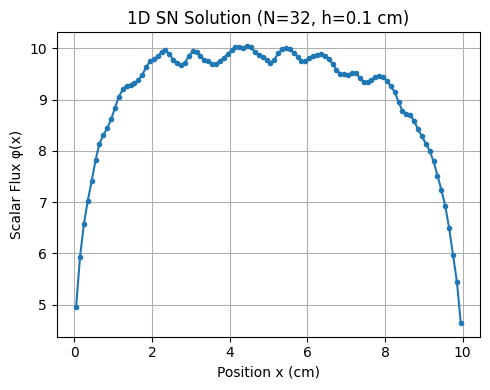

In [4]:
# --- Print results ---
print("\nSample scalar flux values (first 10 cells):")
for j in range(10):
    print(f"x = {j*h:5.2f} cm,  phi = {phi[j]:.6f}")

# --- Plot ---
x_centers = np.linspace(h/2, X - h/2, J)

plt.figure(figsize=(5,4))
plt.plot(x_centers, phi, '-o', lw=1.5, ms=3)
plt.xlabel("Position x (cm)")
plt.ylabel("Scalar Flux φ(x)")
plt.title(f"1D SN Solution (N={N}, h={h} cm)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Generate the source distribution using a GRF

We shall formulate the source value $Q_j$ for each cell by sampling a Gaussian Random Field (GRF) on the cell midpoints using the squared exponential kernel: $$ C(x_i, x_j) = \sigma^2 \exp(-\frac{(x_i-x_j)^2}{2l^2}), \quad \mu(x)\equiv m $$
Here, $m$ is the mean source level, $l$ is the length scale (cm), and $\sigma^2$ is the variance.


In [5]:


def grf_sources(J, h, mean, l, sigma2, n_samples, seed=None, jitter=1e-10):
    """
    Generate Gaussian Random Field samples Q_j on J cell midpoints for a 1-D slab.

    Parameters
    ----------
    J : int
        Number of spatial cells.
    h : float
        Cell width (cm). Midpoints are at (j+0.5)*h.
    mean : float
        Constant mean m of the GRF (cm^-3 s^-1 units if you track them).
    l : float
        Length scale ℓ (cm) of the SE kernel. Smaller ℓ → rougher (higher frequency) fields.
    sigma2 : float
        Variance σ^2 of the GRF.
    n_samples : int
        Number of independent Q realizations to draw.
    seed : int or None
        RNG seed for reproducibility.
    jitter : float
        Small diagonal “nugget” added to the covariance for numerical stability.

    Returns
    -------
    x_mid : (J,) ndarray
        Cell-center coordinates (cm).
    Q : (n_samples, J) ndarray
        GRF samples; if n_samples == 1, you can take Q[0] as a (J,) vector.
    """
    rng = np.random.default_rng(seed)

    # Cell midpoints
    x_mid = (np.arange(J) + 0.5) * h

    # Squared-exponential (RBF) covariance
    # C_ij = sigma^2 * exp( - (x_i - x_j)^2 / (2 l^2) )
    dx = x_mid[:, None] - x_mid[None, :]
    C = sigma2 * np.exp(-(dx**2) / (2.0 * l**2))

    # Stabilize and factor (Cholesky)
    L = np.linalg.cholesky(C + jitter * np.eye(J))

    # Draw n_samples standard normals and map through the factor
    Z = rng.standard_normal((n_samples, J))
    Q = mean + Z @ L.T
    return x_mid, Q


Flux converged in 27 iterations with relative change = 5.094e-09


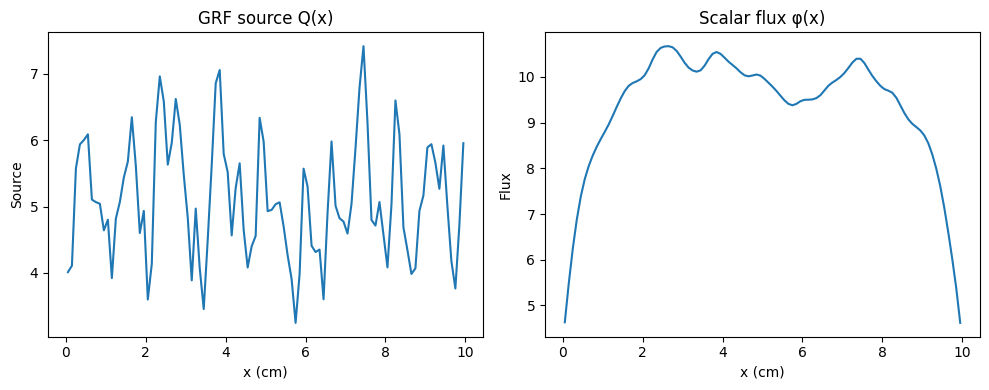

In [6]:
# Geometry and cross section data.
X, h = 10.0, 0.1
J = int(X/h)
Sigma_t, Sigma_a = 1.0, 0.5
N = 4



# 1) Generate one GRF source (paper’s parameters)
x_mid, Qs = grf_sources(J, h, mean=5.0, l=0.1, sigma2=1.0, n_samples=1, seed=123)
Q = Qs[0]



# 2) Solve transport
phi, psi_cell, (mu, w) = SN_1D_Slab(X=X, h=h, Sigma_t=Sigma_t, Sigma_a=Sigma_a, Q=Q, N=N)



# 3) Quick plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(x_mid, Q, '-')
ax[0].set_title('GRF source Q(x)')
ax[0].set_xlabel('x (cm)'); ax[0].set_ylabel('Source')

ax[1].plot(x_mid, phi, '-')
ax[1].set_title('Scalar flux φ(x)')
ax[1].set_xlabel('x (cm)'); ax[1].set_ylabel('Flux')
plt.tight_layout(); plt.show()


In [7]:
Qs

array([[4.01087865, 4.10765508, 5.57570378, 5.9374519 , 6.00329964,
        6.08937492, 5.1054035 , 5.06671152, 5.0417373 , 4.64117292,
        4.80157774, 3.92119564, 4.81887149, 5.06878396, 5.43960381,
        5.67786417, 6.34725804, 5.61417952, 4.60075382, 4.93469437,
        3.59822624, 4.13803225, 6.27590542, 6.96310087, 6.58661316,
        5.6326357 , 5.96154172, 6.62272964, 6.2343557 , 5.47948274,
        4.83250744, 3.88708636, 4.96917573, 4.07115806, 3.45369107,
        4.50057953, 5.62521228, 6.85945427, 7.05955584, 5.79282291,
        5.5203229 , 4.56482724, 5.27992476, 5.65240733, 4.64748008,
        4.0805864 , 4.40071125, 4.55652999, 6.33787619, 5.9801427 ,
        4.93043433, 4.95044891, 5.03508718, 5.06367976, 4.70110555,
        4.26764631, 3.90625361, 3.24562016, 3.97876169, 5.57146274,
        5.30014231, 4.40885043, 4.31408101, 4.35113623, 3.6016085 ,
        4.90467522, 5.98235558, 5.01173071, 4.82332178, 4.77325227,
        4.59254943, 5.04134986, 5.88111518, 6.78

In [8]:
Qs[0]

array([4.01087865, 4.10765508, 5.57570378, 5.9374519 , 6.00329964,
       6.08937492, 5.1054035 , 5.06671152, 5.0417373 , 4.64117292,
       4.80157774, 3.92119564, 4.81887149, 5.06878396, 5.43960381,
       5.67786417, 6.34725804, 5.61417952, 4.60075382, 4.93469437,
       3.59822624, 4.13803225, 6.27590542, 6.96310087, 6.58661316,
       5.6326357 , 5.96154172, 6.62272964, 6.2343557 , 5.47948274,
       4.83250744, 3.88708636, 4.96917573, 4.07115806, 3.45369107,
       4.50057953, 5.62521228, 6.85945427, 7.05955584, 5.79282291,
       5.5203229 , 4.56482724, 5.27992476, 5.65240733, 4.64748008,
       4.0805864 , 4.40071125, 4.55652999, 6.33787619, 5.9801427 ,
       4.93043433, 4.95044891, 5.03508718, 5.06367976, 4.70110555,
       4.26764631, 3.90625361, 3.24562016, 3.97876169, 5.57146274,
       5.30014231, 4.40885043, 4.31408101, 4.35113623, 3.6016085 ,
       4.90467522, 5.98235558, 5.01173071, 4.82332178, 4.77325227,
       4.59254943, 5.04134986, 5.88111518, 6.78922704, 7.41870

## Generate the dataset

A total of 150 source distribution samples are generated using GRF, with each sample evaluated at 100 designated sensor points. These represent the training data. An additional 20 source distribution samples are generated as the test data.


<u> **Aligned dataset** </u>
- Every sample shares the same input and output coordinates.  
  The spatial grid points $x_j$ where the input $Q(x)$ and output $\phi(x)$ are evaluated are identical across all samples.  
- Mathematically:  
  $$
  Q_i = [Q_i(x_1), Q_i(x_2), \ldots, Q_i(x_J)], \quad 
  \phi_i = [\phi_i(x_1), \phi_i(x_2), \ldots, \phi_i(x_J)]
  $$  
  where $x_1, \ldots, x_J$ are shared across all samples.  
- This is the most common setting for DeepONet, allowing data to be stored as matrices of shape `(n_samples, n_points)`.


<u> **Unaligned dataset** </u>
- Each sample $Q_i(x)$ and its corresponding $\phi_i(x)$ are defined on different grids (different $x$ coordinates).  
  For instance, one function might be evaluated on a fine grid, another on a coarse or random grid.  
- Mathematically:  
  $$
  Q_i = [Q_i(x^{(i)}_1), Q_i(x^{(i)}_2), \ldots], \quad 
  \phi_i = [\phi_i(y^{(i)}_1), \phi_i(y^{(i)}_2), \ldots]
  $$  
  with $x_j^{(i)}$ and $y_j^{(i)}$ varying from sample to sample.
- This setup is harder to handle, as DeepONet must learn from irregularly sampled input/output pairs — requiring special batching or interpolation logic.


In [9]:
# ============================================================
# Generate 150 training samples (Q → φ)
# ============================================================

# Problem setup
X = 10.0             # cm, slab length
h = 0.1              # cm, cell width
Sigma_t, Sigma_a = 1.0, 0.5
N = 100              # number of angular bins
J = int(X / h)       # number of spatial cells

# Training parameters for GRF
n_train = 150        # number of training samples
mean = 5.0           # mean of source field
l = 0.1              # length scale of GRF (smaller → more oscillatory)
sigma2 = 1.0         # variance of GRF
seed_train = 123     # RNG seed for reproducibility

# --- Generate 150 GRF training source distributions ---
x_mid, Q_train = grf_sources(J, h, mean=mean, l=l, sigma2=sigma2,
                             n_samples=n_train, seed=seed_train)

# --- Compute scalar flux φ(x) for each training source ---
phi_train = np.empty_like(Q_train)

for i in range(n_train):
    phi_train[i], _, _ = SN_1D_Slab(X=X, h=h, Sigma_t=Sigma_t, Sigma_a=Sigma_a, Q=Q_train[i], N=N);

print(f"\nTraining data generated: Q_train {Q_train.shape}, phi_train {phi_train.shape}")




Flux converged in 27 iterations with relative change = 5.166e-09
Flux converged in 27 iterations with relative change = 5.045e-09
Flux converged in 27 iterations with relative change = 4.906e-09
Flux converged in 26 iterations with relative change = 9.787e-09
Flux converged in 27 iterations with relative change = 4.966e-09
Flux converged in 27 iterations with relative change = 5.038e-09
Flux converged in 27 iterations with relative change = 5.162e-09
Flux converged in 26 iterations with relative change = 9.752e-09
Flux converged in 26 iterations with relative change = 9.917e-09
Flux converged in 26 iterations with relative change = 9.847e-09
Flux converged in 27 iterations with relative change = 4.903e-09
Flux converged in 26 iterations with relative change = 9.863e-09
Flux converged in 27 iterations with relative change = 4.886e-09
Flux converged in 27 iterations with relative change = 4.994e-09
Flux converged in 27 iterations with relative change = 5.182e-09
Flux converged in 27 iter

In [10]:
Q_train.shape

(150, 100)

In [11]:
phi_train.shape

(150, 100)

In [12]:

# ============================================================
# Generate 20 test samples (Q → φ)
# ============================================================

n_test = 20
seed_test = 123   # use a different random seed to ensure independence

# --- Generate 20 GRF test source distributions ---
x_mid, Q_test = grf_sources(J, h, mean=mean, l=l, sigma2=sigma2,
                            n_samples=n_test, seed=seed_test)

# --- Compute scalar flux φ(x) for each test source ---
phi_test = np.empty_like(Q_test)
for i in range(n_test):
    phi_test[i], _, _ = SN_1D_Slab(X=X, h=h, Sigma_t=Sigma_t, Sigma_a=Sigma_a, Q=Q_test[i], N=N);

print(f"Test data generated: Q_test {Q_test.shape}, phi_test {phi_test.shape}")


Flux converged in 27 iterations with relative change = 5.166e-09
Flux converged in 27 iterations with relative change = 5.045e-09
Flux converged in 27 iterations with relative change = 4.906e-09
Flux converged in 26 iterations with relative change = 9.787e-09
Flux converged in 27 iterations with relative change = 4.966e-09
Flux converged in 27 iterations with relative change = 5.038e-09
Flux converged in 27 iterations with relative change = 5.162e-09
Flux converged in 26 iterations with relative change = 9.752e-09
Flux converged in 26 iterations with relative change = 9.917e-09
Flux converged in 26 iterations with relative change = 9.847e-09
Flux converged in 27 iterations with relative change = 4.903e-09
Flux converged in 26 iterations with relative change = 9.863e-09
Flux converged in 27 iterations with relative change = 4.886e-09
Flux converged in 27 iterations with relative change = 4.994e-09
Flux converged in 27 iterations with relative change = 5.182e-09
Flux converged in 27 iter

Training sources: (150, 100) Fluxes: (150, 100)
Test sources: (20, 100) Fluxes: (20, 100)


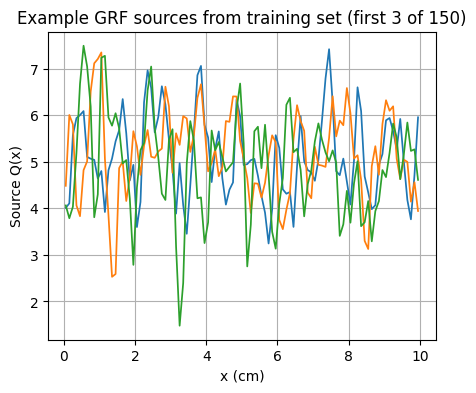

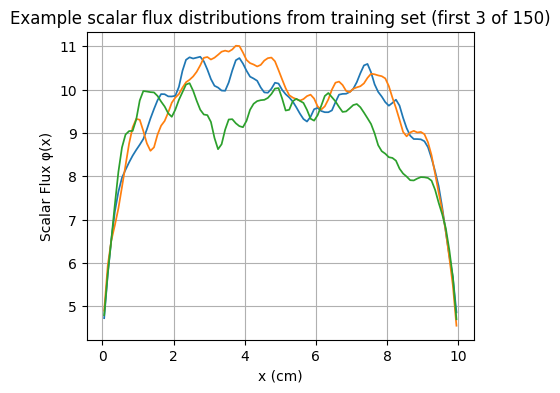

In [13]:
print("Training sources:", Q_train.shape, "Fluxes:", phi_train.shape)
print("Test sources:", Q_test.shape, "Fluxes:", phi_test.shape)


# Plot some training sources

plt.figure(figsize=(5,4))
for i in range(3):
    plt.plot(x_mid, Q_train[i], lw=1.25)
plt.title("Example GRF sources from training set (first 3 of 150)")
plt.xlabel("x (cm)"); plt.ylabel("Source Q(x)")
plt.grid(True); plt.show()



# Plot some training/ fluxes

plt.figure(figsize=(5,4))
for i in range(3):
    plt.plot(x_mid, phi_train[i], lw=1.25)
plt.title("Example scalar flux distributions from training set (first 3 of 150)")
plt.xlabel("x (cm)"); plt.ylabel("Scalar Flux φ(x)")
plt.grid(True); plt.show()


## DeepONet code

- The input function to the branch net is the neutron source distribution $Q(x)$ evaluated at fixed sensor points $x$.
- The trunk net takes the target position $x$ within the output domain.
- The outputs of the branch net and trunk net are combined through a dot product, producing DeepONet’s prediction, which approximates the scalar flux $\phi_0(x)$.

In [14]:
# !pip install deepxde

In [15]:
# !python -m deepxde.backend.set_default_backend paddle

# !python -m deepxde.backend.set_default_backend pytorch


In [16]:
import deepxde as dde


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [17]:
print(Q_train.shape)
print(phi_train.shape)

print(Q_test.shape)
print(phi_test.shape)

print(x_mid.shape)

(150, 100)
(150, 100)
(20, 100)
(20, 100)
(100,)


### Normalize the dataset

In [18]:
x_mid

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25,
       3.35, 3.45, 3.55, 3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35,
       4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45,
       5.55, 5.65, 5.75, 5.85, 5.95, 6.05, 6.15, 6.25, 6.35, 6.45, 6.55,
       6.65, 6.75, 6.85, 6.95, 7.05, 7.15, 7.25, 7.35, 7.45, 7.55, 7.65,
       7.75, 7.85, 7.95, 8.05, 8.15, 8.25, 8.35, 8.45, 8.55, 8.65, 8.75,
       8.85, 8.95, 9.05, 9.15, 9.25, 9.35, 9.45, 9.55, 9.65, 9.75, 9.85,
       9.95])

In [19]:
x_mid = x_mid / np.max(x_mid)

In [20]:
# NORMALIZATION USING MEAN AND STANDARD DEVIATION (Z-SCORE NORMALIZATION)

# Compute means and stds from training set
Q_mean, Q_std = Q_train.mean(), Q_train.std()
phi_mean, phi_std = phi_train.mean(), phi_train.std()

# Normalize using training mean and training standard deviation
Q_train_n  = (Q_train - Q_mean) / Q_std
phi_train_n = (phi_train - phi_mean) / phi_std
Q_test_n   = (Q_test  - Q_mean) / Q_std
phi_test_n = (phi_test - phi_mean) / phi_std

# Re-build data containers
X_train = (Q_train_n.astype(np.float32),
           x_mid.reshape(-1,1).astype(np.float32))
y_train = phi_train_n.astype(np.float32)
X_test  = (Q_test_n.astype(np.float32),
           x_mid.reshape(-1,1).astype(np.float32))
y_test  = phi_test_n.astype(np.float32)

data = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=y_train, X_test=X_test,   y_test=y_test)


In [21]:
# # NORMALIZATION USING MIN-MAX NORMALIZATION


# # --- Compute min and max from TRAINING data only ---
# Q_train_min, Q_train_max = Q_train.min(), Q_train.max()
# Q_test_min, Q_test_max = Q_test.min(), Q_test.max()

# phi_train_min, phi_train_max = phi_train.min(), phi_train.max()
# phi_test_min, phi_test_max = phi_test.min(), phi_test.max()

# # --- Normalize between 0 and 1 ---
# Q_train_n  = (Q_train - Q_train_min) / (Q_train_max - Q_train_min)
# phi_train_n = (phi_train - phi_train_min) / (phi_train_max - phi_train_min)

# Q_test_n   = (Q_test  - Q_test_min) / (Q_test_max - Q_test_min)      
# phi_test_n = (phi_test - phi_test_min) / (phi_train_max - phi_test_min)


# X_train = (Q_train_n.astype(np.float32), x_mid.reshape(-1,1).astype(np.float32))
# y_train = phi_train_n.astype(np.float32)

# X_test  = (Q_test_n.astype(np.float32), x_mid.reshape(-1,1).astype(np.float32))
# y_test  = phi_test_n.astype(np.float32)

# data = dde.data.TripleCartesianProd(
#     X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
# )


In [22]:
Q_train[0]

array([4.01087865, 4.10765508, 5.57570378, 5.9374519 , 6.00329964,
       6.08937492, 5.1054035 , 5.06671152, 5.0417373 , 4.64117292,
       4.80157774, 3.92119564, 4.81887149, 5.06878396, 5.43960381,
       5.67786417, 6.34725804, 5.61417952, 4.60075382, 4.93469437,
       3.59822624, 4.13803225, 6.27590542, 6.96310087, 6.58661316,
       5.6326357 , 5.96154172, 6.62272964, 6.2343557 , 5.47948274,
       4.83250744, 3.88708636, 4.96917573, 4.07115806, 3.45369107,
       4.50057953, 5.62521228, 6.85945427, 7.05955584, 5.79282291,
       5.5203229 , 4.56482724, 5.27992476, 5.65240733, 4.64748008,
       4.0805864 , 4.40071125, 4.55652999, 6.33787619, 5.9801427 ,
       4.93043433, 4.95044891, 5.03508718, 5.06367976, 4.70110555,
       4.26764631, 3.90625361, 3.24562016, 3.97876169, 5.57146274,
       5.30014231, 4.40885043, 4.31408101, 4.35113623, 3.6016085 ,
       4.90467522, 5.98235558, 5.01173071, 4.82332178, 4.77325227,
       4.59254943, 5.04134986, 5.88111518, 6.78922704, 7.41870

In [23]:
Q_train_n[0]

array([-1.00135977, -0.90481888,  0.55965668,  0.92052433,  0.98621179,
        1.07207758,  0.09050108,  0.05190327,  0.02698984, -0.3725996 ,
       -0.21258519, -1.09082449, -0.19533353,  0.05397067,  0.42388796,
        0.66156841,  1.32933302,  0.59803877, -0.41292031, -0.07979256,
       -1.41300781, -0.87451565,  1.25815407,  1.94367693,  1.56810557,
        0.61645003,  0.94455552,  1.60413414,  1.21670548,  0.46366983,
       -0.18173077, -1.12485075, -0.04539512, -0.94122707, -1.55719118,
       -0.51285079,  0.60904468,  1.8402826 ,  2.03989713,  0.77624735,
        0.50441059, -0.44875945,  0.26459756,  0.63617354, -0.36630778,
       -0.93182168, -0.61247599, -0.4570365 ,  1.31997401,  0.96311122,
       -0.08404222, -0.06407636,  0.0203559 ,  0.0488789 , -0.31281284,
       -0.74521706, -1.10573016, -1.76475567, -1.03339856,  0.55542596,
        0.28476591, -0.60435663, -0.69889538, -0.66193035, -1.40963378,
       -0.10973864,  0.96531871, -0.00294372, -0.19089407, -0.24

In [24]:
Q_test[0]

array([4.01087865, 4.10765508, 5.57570378, 5.9374519 , 6.00329964,
       6.08937492, 5.1054035 , 5.06671152, 5.0417373 , 4.64117292,
       4.80157774, 3.92119564, 4.81887149, 5.06878396, 5.43960381,
       5.67786417, 6.34725804, 5.61417952, 4.60075382, 4.93469437,
       3.59822624, 4.13803225, 6.27590542, 6.96310087, 6.58661316,
       5.6326357 , 5.96154172, 6.62272964, 6.2343557 , 5.47948274,
       4.83250744, 3.88708636, 4.96917573, 4.07115806, 3.45369107,
       4.50057953, 5.62521228, 6.85945427, 7.05955584, 5.79282291,
       5.5203229 , 4.56482724, 5.27992476, 5.65240733, 4.64748008,
       4.0805864 , 4.40071125, 4.55652999, 6.33787619, 5.9801427 ,
       4.93043433, 4.95044891, 5.03508718, 5.06367976, 4.70110555,
       4.26764631, 3.90625361, 3.24562016, 3.97876169, 5.57146274,
       5.30014231, 4.40885043, 4.31408101, 4.35113623, 3.6016085 ,
       4.90467522, 5.98235558, 5.01173071, 4.82332178, 4.77325227,
       4.59254943, 5.04134986, 5.88111518, 6.78922704, 7.41870

In [25]:
Q_test_n[0]

array([-1.00135977, -0.90481888,  0.55965668,  0.92052433,  0.98621179,
        1.07207758,  0.09050108,  0.05190327,  0.02698984, -0.3725996 ,
       -0.21258519, -1.09082449, -0.19533353,  0.05397067,  0.42388796,
        0.66156841,  1.32933302,  0.59803877, -0.41292031, -0.07979256,
       -1.41300781, -0.87451565,  1.25815407,  1.94367693,  1.56810557,
        0.61645003,  0.94455552,  1.60413414,  1.21670548,  0.46366983,
       -0.18173077, -1.12485075, -0.04539512, -0.94122707, -1.55719118,
       -0.51285079,  0.60904468,  1.8402826 ,  2.03989713,  0.77624735,
        0.50441059, -0.44875945,  0.26459756,  0.63617354, -0.36630778,
       -0.93182168, -0.61247599, -0.4570365 ,  1.31997401,  0.96311122,
       -0.08404222, -0.06407636,  0.0203559 ,  0.0488789 , -0.31281284,
       -0.74521706, -1.10573016, -1.76475567, -1.03339856,  0.55542596,
        0.28476591, -0.60435663, -0.69889538, -0.66193035, -1.40963378,
       -0.10973864,  0.96531871, -0.00294372, -0.19089407, -0.24

In [26]:
print("X_train shape:", X_train[0].shape, X_train[1].shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test[0].shape, X_test[1].shape)
print("y_test shape:", y_test.shape)

X_train shape: (150, 100) (100, 1)
y_train shape: (150, 100)
X_test shape: (20, 100) (100, 1)
y_test shape: (20, 100)


In [27]:
X_train[0][0]

array([-1.0013598 , -0.9048189 ,  0.5596567 ,  0.9205243 ,  0.9862118 ,
        1.0720776 ,  0.09050108,  0.05190327,  0.02698984, -0.3725996 ,
       -0.2125852 , -1.0908245 , -0.19533353,  0.05397067,  0.42388797,
        0.6615684 ,  1.3293331 ,  0.5980388 , -0.41292033, -0.07979256,
       -1.4130079 , -0.87451565,  1.258154  ,  1.943677  ,  1.5681056 ,
        0.61645   ,  0.9445555 ,  1.6041341 ,  1.2167054 ,  0.46366984,
       -0.18173078, -1.1248507 , -0.04539512, -0.9412271 , -1.5571911 ,
       -0.51285076,  0.6090447 ,  1.8402826 ,  2.0398972 ,  0.7762473 ,
        0.50441056, -0.44875947,  0.26459756,  0.63617355, -0.3663078 ,
       -0.9318217 , -0.612476  , -0.4570365 ,  1.3199741 ,  0.9631112 ,
       -0.08404222, -0.06407636,  0.0203559 ,  0.0488789 , -0.31281283,
       -0.7452171 , -1.1057302 , -1.7647556 , -1.0333985 ,  0.55542594,
        0.2847659 , -0.60435665, -0.6988954 , -0.6619304 , -1.4096338 ,
       -0.10973864,  0.9653187 , -0.00294372, -0.19089407, -0.24

### Train the model

In [28]:
# help(dde.data.TripleCartesianProd)
# help(dde.nn.DeepONetCartesianProd)

In [29]:
# Choose the branch and trunk networks.
# The branch net is chosen as a fully connected neural network of containing two hidden layers, with the size [100, 200, 200, 100].
# The trunk net is also fully connected neural network with two hidden layers, having the size [1, 200, 200, 100].
# The activation function in all cases is ReLU.
# The model is trained with Adam optimizer and learning rate 0.00001 for 10000 iterations in the cited paper.



#---------------------------------- Other architectures -------------------
# BN(100, 150, 100, 100, 80, 50)
# TN(1, 50, 100, 80, 80, 50)

# BN(100, 150, 100, 50)
# TN(1, 150, 100, 50)

# BN(100, 300, 200, 100)
# TN(1, 300, 200, 100)


# net = dde.nn.DeepONetCartesianProd(
#     [100, 200, 300, 200, 100],
#     [1, 200, 300, 200, 100],
#     "relu",
#     "Glorot normal"
# )


#--------------------------------------------------------------------------

net = dde.nn.DeepONetCartesianProd(
    [100, 200, 200, 100],
    [1, 200, 200, 100],
    "relu",
    "Glorot normal",
)



model = dde.Model(data, net)


# # Compile and train the model
# model.compile("adam", loss="MSE", lr=0.00001, metrics=["mean l2 relative error"])
# loss_history, train_state = model.train(iterations=15000)



In [30]:
# Initial training setup (use larger learning rate first)
model.compile("adam", lr=1e-3, metrics=["mean l2 relative error"])

# Train for the first stage with faster learning
loss_history, train_state = model.train(iterations=20000, display_every=1000)

# Lower the learning rate
model.compile("adam", lr=1e-5, metrics=["mean l2 relative error"])

# Train for another 20k iterations or until convergence
loss_history, train_state = model.train(iterations=20000, display_every=1000)


Compiling model...
'compile' took 6.412080 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.02e+00]    [1.03e+00]    [1.01e+00]    
1000      [2.46e-02]    [2.36e-02]    [1.54e-01]    
2000      [2.55e-02]    [2.46e-02]    [1.57e-01]    
3000      [1.22e-02]    [1.24e-02]    [1.11e-01]    
4000      [8.37e-03]    [8.47e-03]    [9.24e-02]    
5000      [5.41e-03]    [5.49e-03]    [7.42e-02]    
6000      [1.24e-02]    [1.25e-02]    [1.12e-01]    
7000      [3.81e-03]    [3.92e-03]    [6.24e-02]    
8000      [3.23e-03]    [3.32e-03]    [5.74e-02]    
9000      [2.69e-03]    [2.82e-03]    [5.29e-02]    
10000     [3.45e-03]    [3.61e-03]    [6.03e-02]    
11000     [3.85e-03]    [4.02e-03]    [6.37e-02]    
12000     [2.28e-03]    [2.42e-03]    [4.92e-02]    
13000     [2.21e-03]    [2.29e-03]    [4.80e-02]    
14000     [1.70e-03]    [1.78e-03]    [4.23e-02]    
15000     [1.52e-03]    [1.59e-03]    [4.00e-02]    
16000     [3.22e-03]    [3.29e-03]

In [31]:
# help(model.compile)

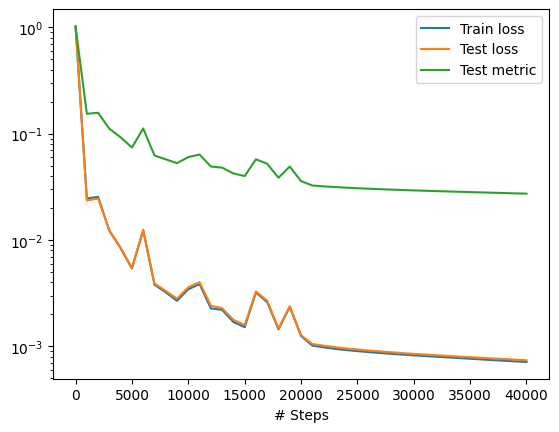

In [32]:
# Plot the loss trajectory

dde.utils.plot_loss_history(loss_history)
plt.show()

### Evaluate the model on the training and test data.

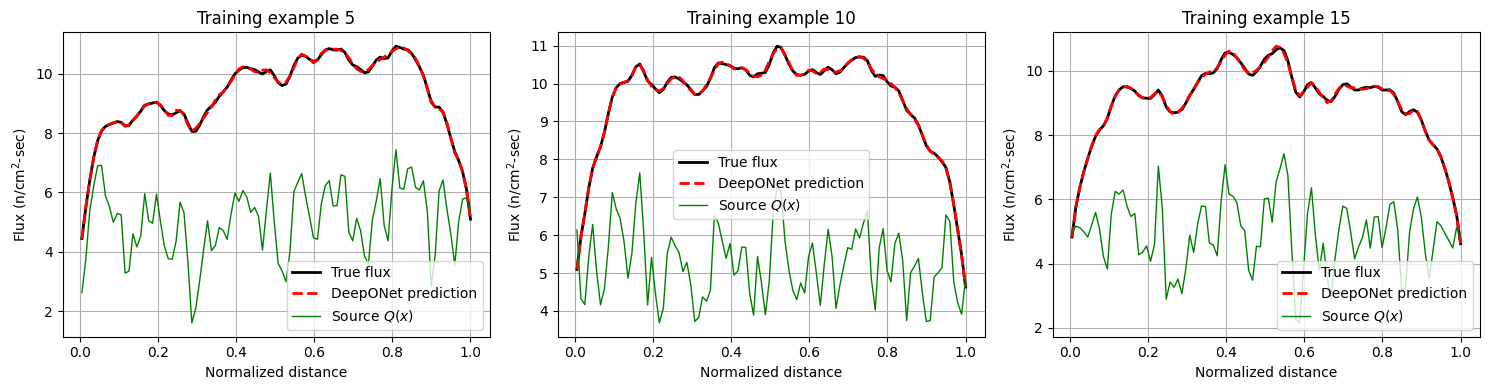

In [41]:
# EVALUATION ON SOME OF THE TRAINING DATA



# # === Predict and denormalize ===
# y_pred_train = model.predict(X_train).reshape(y_train.shape)
# y_pred_train = y_pred_train * (phi_train_max - phi_train_min) + phi_train_min  # denormalize prediction

# # === Also denormalize the true flux ===
# y_true_train = y_train * (phi_train_max - phi_train_min) + phi_train_min       # bring back to original scale


# === Predict and denormalize ===
y_pred_train = model.predict(X_train).reshape(y_train.shape)
y_pred_train = y_pred_train * phi_std + phi_mean   # denormalize prediction

# === Also denormalize the true flux ===
y_true_train = y_train * phi_std + phi_mean        # bring back to original scale


# Choose three sample indices to visualize
samples = [5, 10, 15]   # pick any training sample indices

plt.figure(figsize=(15, 4))  # width=15, height=4 for 3 plots side by side

for idx, i in enumerate(samples):
    plt.subplot(1, 3, idx + 1)  # 1 row, 3 columns, subplot index
    plt.plot(x_mid, y_true_train[i], 'k-', lw=2, label='True flux')
    plt.plot(x_mid, y_pred_train[i], 'r--', lw=2, label='DeepONet prediction')
    plt.plot(x_mid, Q_train[i], 'g-', lw=1, label='Source $Q(x)$')
    plt.xlabel("Normalized distance")
    plt.ylabel("Flux (n/cm$^2$-sec)")
    plt.title(f"Training example {i}")
    plt.grid(True)
    plt.legend(loc='best')
    
    # if idx == 0:
    #     plt.legend(loc='best')  # only add legend to first subplot to avoid clutter

plt.tight_layout()
plt.show()



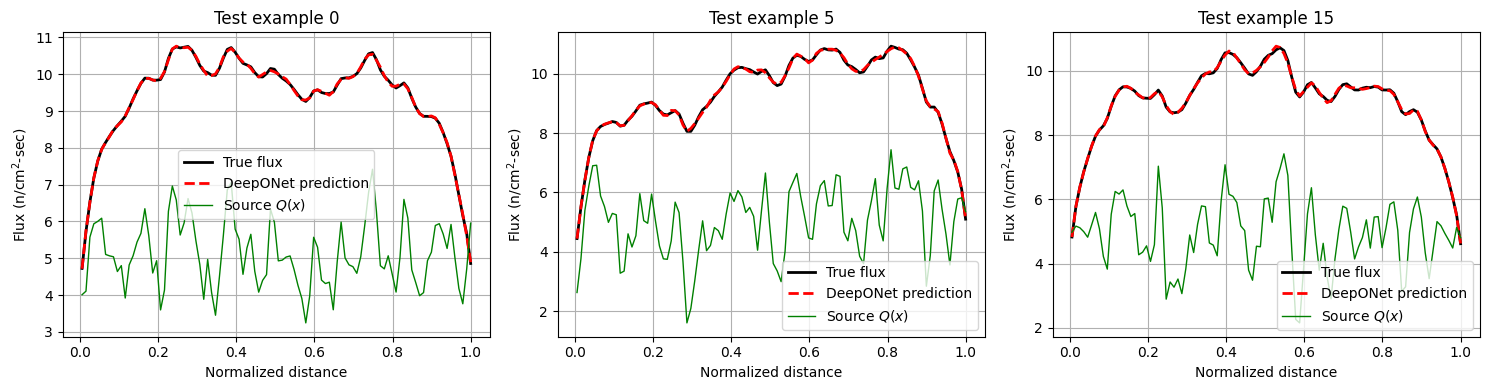

In [42]:
# EVALUATION ON SOME OF THE TEST DATA



# # === Predict and denormalize ===
# y_pred_test = model.predict(X_test).reshape(y_test.shape)
# y_pred_test = y_pred_test * (phi_test_max - phi_test_min) + phi_test_min  # denormalize prediction

# # === Also denormalize the true flux ===
# y_true_test = y_test * (phi_test_max - phi_test_min) + phi_test_min       # bring back to original scale


# === Predict and denormalize ===
y_pred_test = model.predict(X_test).reshape(y_test.shape)
y_pred_test = y_pred_test * phi_std + phi_mean    # denormalize prediction

# === Also denormalize the true flux ===
y_true_test = y_test * phi_std + phi_mean         # bring back to original scale


# Choose three sample indices to visualize
samples = [0, 5, 15]   # pick any test sample indices

plt.figure(figsize=(15, 4))  # width=15, height=4 for 3 plots side by side

for idx, i in enumerate(samples):
    plt.subplot(1, 3, idx + 1)  # 1 row, 3 columns, subplot index
    plt.plot(x_mid, y_true_test[i], 'k-', lw=2, label='True flux')
    plt.plot(x_mid, y_pred_test[i], 'r--', lw=2, label='DeepONet prediction')
    plt.plot(x_mid, Q_test[i], 'g-', lw=1, label='Source $Q(x)$')
    plt.xlabel("Normalized distance")
    plt.ylabel("Flux (n/cm$^2$-sec)")
    plt.title(f"Test example {i}")
    plt.grid(True)
    plt.legend(loc='best')

plt.tight_layout()
plt.show()


### Compute the relative errors

In [35]:

def l2_norm_rows(A):
    """Compute L2 norm for each row (sample)."""
    return np.sqrt(np.sum(A**2, axis=1))

def compute_l2_metrics(phi_pred, phi_true, name="set"):
    """
    phi_pred, phi_true : arrays of shape (N, J)
      (e.g., N=20 test samples, J=100 spatial points)
    
    Returns a dict with:
      - l2_true:     ||phi_true||_2 per sample
      - l2_error:    ||phi_pred - phi_true||_2 per sample
      - rel_l2:      l2_error / l2_true per sample
      - mean_rel_l2: mean(rel_l2) over all samples
    """
    assert phi_pred.shape == phi_true.shape, "Shapes must match (N, J)."
    N = phi_true.shape[0]

    # Compute L2 norm for true flux
    l2_true  = l2_norm_rows(phi_true)                      # (N,)

    # Compute L2 error for each sample
    l2_error = l2_norm_rows(phi_pred - phi_true)           # (N,)

    # Avoid divide-by-zero: set denom to 1 if l2_true is zero
    denom = np.where(l2_true > 0, l2_true, 1.0)
    rel_l2 = l2_error / denom                              # (N,)

    # Mean relative L2 error
    mean_rel_l2 = np.mean(rel_l2)

    # Pretty print results
    print(f"\n--- L2 metrics ({name}) ---")
    print("\nPer-sample L2 (true):\n", np.round(l2_true, 6))
    print("\nPer-sample L2 (error):\n", np.round(l2_error, 6))
    print("\nPer-sample relative L2 error:\n", np.round(rel_l2, 6))
    print(f"\nMean relative L2 error ({name}): {mean_rel_l2:.6f}")

    return {
        "l2_true": l2_true,
        "l2_error": l2_error,
        "rel_l2": rel_l2,
        "mean_rel_l2": mean_rel_l2,
    }



In [36]:
test_metrics = compute_l2_metrics(y_pred_test, y_true_test, name="test")



--- L2 metrics (test) ---

Per-sample L2 (true):
 [94.569893 95.761648 90.277065 92.605187 89.467913 93.688255 90.232218
 93.599131 95.779504 92.981596 96.862241 88.650143 95.468846 91.979846
 92.080861 91.0782   98.702852 90.195776 88.56794  91.411998]

Per-sample L2 (error):
 [0.295589 0.283167 0.447397 0.353463 0.421858 0.443515 0.359069 0.269961
 0.367274 0.333988 0.333022 0.304934 0.399551 0.358688 0.376947 0.404441
 0.36218  0.367143 0.353881 0.395693]

Per-sample relative L2 error:
 [0.003126 0.002957 0.004956 0.003817 0.004715 0.004734 0.003979 0.002884
 0.003835 0.003592 0.003438 0.00344  0.004185 0.0039   0.004094 0.004441
 0.003669 0.004071 0.003996 0.004329]

Mean relative L2 error (test): 0.003908


In [43]:
train_metrics = compute_l2_metrics(y_pred_train, y_true_train, name="train")



--- L2 metrics (train) ---

Per-sample L2 (true):
 [94.569893 95.761648 90.277065 92.605187 89.467913 93.688255 90.232218
 93.599131 95.779504 92.981596 96.862241 88.650143 95.468846 91.979846
 92.080861 91.0782   98.702852 90.195776 88.56794  91.411998 93.951784
 94.686601 93.166264 86.614704 88.094468 90.605826 91.882425 86.506706
 94.929916 95.745843 92.759471 90.27754  91.486404 95.570268 92.472963
 94.630323 90.16236  92.68126  93.368154 96.152366 92.420954 91.599063
 95.694233 92.515501 91.880616 93.065467 90.204601 93.87861  94.835216
 91.116375 93.895162 87.262724 95.653563 91.680413 91.896788 93.889446
 95.889377 95.807583 94.698724 92.353118 90.192819 95.554583 93.163962
 88.329743 87.281783 90.122483 95.786235 95.784196 97.05765  94.767777
 91.861579 93.070656 94.237917 89.817957 85.912182 93.241806 93.616997
 94.038324 87.560399 92.417804 93.817032 91.969052 91.966165 96.327727
 92.212028 94.548372 90.500671 88.69429  89.380999 89.820445 92.865978
 98.958448 93.259554 94.8